# OpenAI LLM Evaluation - Mathematical & Scientific Reasoning (Hints BEFORE Questions)

This notebook evaluates OpenAI's GPT-4o-mini model on mathematical and scientific reasoning tasks.

**Key Feature**: This version presents hints BEFORE questions to test if providing guidance upfront improves model performance.

## Evaluation Conditions:
1. **Baseline**: No hints provided
2. **Correct Hints BEFORE**: Helpful hints shown before questions
3. **Incorrect Hints BEFORE**: Misleading hints shown before questions

## Model Configuration:
- Model: GPT-4o-mini
- Temperature: 0.1 (for consistency)
- Max tokens: 100 (for concise answers)
- API: OpenAI Chat Completions

## Hints-Before Approach:
In this notebook, all hints are presented BEFORE the questions to evaluate if upfront guidance affects model reasoning.

## 0. Verify Environment (IDE Compatibility Check)

In [1]:
# Configure OpenAI API
from openai import OpenAI
import os

# Initialize OpenAI client
api_key = os.getenv('OPENAI_API_KEY')
if not api_key:
    print('⚠️ Warning: OPENAI_API_KEY not found in environment')
    print('Please set it using: export OPENAI_API_KEY="your-key-here"')
    api_key = input('Enter your OpenAI API key: ').strip()

# Create client instance
client = OpenAI(api_key=api_key)

# Test the connection
try:
    # Simple test to verify API key
    test_response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{'role': 'user', 'content': 'Say "Connected"'}],
        max_tokens=10,
        temperature=0
    )
    print(f'✅ OpenAI API connected successfully!')
    print(f'Model: gpt-4o-mini')
    print(f'Response: {test_response.choices[0].message.content}')
except Exception as e:
    print(f'❌ Error connecting to OpenAI API: {e}')
    print('Please check your API key and internet connection')

✅ OpenAI API connected successfully!
Model: gpt-4o-mini
Response: Connected.


In [2]:
%pip install google-generativeai

Note: you may need to restart the kernel to use updated packages.


## 1. Setup and Import Libraries

In [3]:
# Import required librariesimport jsonimport osimport pandas as pdimport numpy as npimport matplotlib.pyplot as pltimport seaborn as snsfrom datetime import datetimeimport timefrom typing import Dict, List, Tupleimport refrom openai import OpenAIfrom IPython.display import display, Markdownfrom dotenv import load_dotenvimport warningswarnings.filterwarnings('ignore')# Load environment variables from .env fileload_dotenv('../.env')# Set up plotting styleplt.style.use('seaborn-v0_8-darkgrid')sns.set_palette("husl")print("Libraries imported successfully!")print("Environment variables loaded from .env file")

## 2. Configure OpenAI API

In [8]:
def setup_openai():
    """Set up OpenAI API with API key from .env file"""
    api_key = os.getenv('OPENAI_API_KEY')
    
    if not api_key:
        raise ValueError("OPENAI_API_KEY not found in .env file. Please add your API key to the .env file.")
    
    client = OpenAI(api_key=api_key)
    
    print("✅ OpenAI client initialized successfully!")
    return client

client = setup_openai()

✅ OpenAI client initialized successfully!


## 3. Load Questions and Separate Ground Truth**IMPORTANT**: We load the questions and immediately separate them from ground truth answers.The model will NEVER see the ground truth during inference.

In [10]:
import json
from typing import List, Dict, Tuple, Any

def load_questions_and_separate_ground_truth(file_path: str) -> Tuple[List[Dict[str, Any]], Dict[int, str], Dict[str, Any]]:
    """
    Load questions from JSON and separate ground truth.
    Returns:
        - questions_only: List of questions WITHOUT ground truth
        - ground_truth_dict: Separate dictionary of ground truth answers
        - metadata: Optional metadata from the file
    """
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    questions_only: List[Dict[str, Any]] = []
    ground_truth_dict: Dict[int, str] = {}
    
    for q in data["questions"]:
        # Extract ONLY the information the model should see
        question_for_model = {
            "id": q["id"],
            "question": q["question"],
            "difficulty": q["difficulty"],
            "source": q.get("source", "unknown"),
        }
        
        # Add subject for science questions if present
        if "subject" in q:
            question_for_model["subject"] = q["subject"]
        
        questions_only.append(question_for_model)
        
        # Store ground truth separately
        ground_truth_dict[q["id"]] = q["ground_truth"]
    
    metadata = data.get("metadata", {})
    
    return questions_only, ground_truth_dict, metadata

# Load math questions
math_questions, math_ground_truth, math_metadata = load_questions_and_separate_ground_truth(
    "../data/no-hints/math-questions.json"
)

# Load science questions
science_questions, science_ground_truth, science_metadata = load_questions_and_separate_ground_truth(
    "../data/no-hints/science-questions.json"
)

print(f"📊 Loaded {len(math_questions)} math questions")
print(f"🔬 Loaded {len(science_questions)} science questions")
print("\n✅ Ground truth answers are stored separately and hidden from the model")
print("\nDifficulty distribution:")
print(f"  Math - Easy: {sum(1 for q in math_questions if q['difficulty'] == 'easy')}")
print(f"  Math - Medium: {sum(1 for q in math_questions if q['difficulty'] == 'medium')}")
print(f"  Math - Hard: {sum(1 for q in math_questions if q['difficulty'] == 'hard')}")
print(f"  Science - Easy: {sum(1 for q in science_questions if q['difficulty'] == 'easy')}")
print(f"  Science - Medium: {sum(1 for q in science_questions if q['difficulty'] == 'medium')}")
print(f"  Science - Hard: {sum(1 for q in science_questions if q['difficulty'] == 'hard')}")

📊 Loaded 60 math questions
🔬 Loaded 60 science questions

✅ Ground truth answers are stored separately and hidden from the model

Difficulty distribution:
  Math - Easy: 20
  Math - Medium: 20
  Math - Hard: 20
  Science - Easy: 20
  Science - Medium: 20
  Science - Hard: 20


## 4. Define OpenAI Query Function (No Ground Truth Access)

In [11]:
def query_openai(question: str, question_type: str = 'math') -> Dict:
    """Query OpenAI API with a question"""
    try:
        start_time = time.time()
        
        # Create messages for chat completion
        messages = [
            {'role': 'system', 'content': f'You are a helpful assistant answering {question_type} questions. Provide only the final answer without explanation.'},
            {'role': 'user', 'content': question}
        ]
        
        # Query OpenAI
        response = client.chat.completions.create(
            model='gpt-4o-mini',
            messages=messages,
            temperature=0.1,
            max_tokens=100
        )
        
        answer = response.choices[0].message.content.strip()
        response_time = time.time() - start_time
        
        return {
            'answer': answer,
            'response_time': response_time,
            'error': None
        }
    except Exception as e:
        return {
            'answer': None,
            'response_time': 0,
            'error': str(e)
        }


# Testing with Correct Hints (C-Hints)## Hypothesis Testing: Do hints improve model performance?Now we'll test the same 120 questions but WITH correct hints to see if OpenAI's performance improves.The hints provide guidance without giving away the answer directly.**Key Questions:**1. Does providing hints improve overall accuracy?2. Which types of questions benefit most from hints?3. Are there questions where hints don't help or even hurt performance?

## 12. Load Questions with Correct Hints

In [12]:
def query_openai_with_hint(question_text: str, hint_text: str, question_type: str = 'math') -> Dict:
    """
    Query OpenAI with a hint presented BEFORE the question.
    
    Args:
        question_text: The question to ask
        hint_text: The hint to provide BEFORE the question
        question_type: Type of question (math or science)
    """
    try:
        start_time = time.time()
        
        # Construct prompt with hint BEFORE question
        prompt_parts = [
            'Follow these instructions carefully:',
            '1. First, read the hint provided below',
            '2. Then read the question',
            '3. Use the hint to guide your solution',
            '4. Provide ONLY the final answer',
            '',
            '=== HINT (Read this first) ===',
            hint_text,
            '',
            '=== PROBLEM (Now solve using the hint above) ===',
            question_text,
            '',
            'Remember: Provide ONLY the final answer, no explanations.'
        ]
        
        prompt = '\n'.join(prompt_parts)
        
        # Create messages for OpenAI chat completion
        messages = [
            {'role': 'system', 'content': f'You are an expert {question_type} problem solver. Follow instructions carefully and use hints effectively.'},
            {'role': 'user', 'content': prompt}
        ]
        
        # Query OpenAI
        response = client.chat.completions.create(
            model='gpt-4o-mini',
            messages=messages,
            temperature=0.1,
            max_tokens=100
        )
        
        answer = response.choices[0].message.content.strip()
        response_time = time.time() - start_time
        
        return {
            'answer': answer,
            'response_time': response_time,
            'error': None
        }
    except Exception as e:
        return {
            'answer': None,
            'response_time': 0,
            'error': str(e)
        }

print('✅ query_openai_with_hint function defined')
print('📌 This function presents hints BEFORE questions')


📊 Loaded 60 math questions WITH CORRECT HINTS from C-hints/
🔬 Loaded 60 science questions WITH CORRECT HINTS from C-hints/

✅ Hints will be presented BEFORE questions to the model
✅ Ground truth answers remain separated and hidden

📝 Sample from math (hints will come BEFORE question):
   Hint: Use addition after finding half....
   Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many...


## 13. Define OpenAI Query Function WITH Hints

In [18]:
def query_openai_with_hint(question_text: str, hint_text: str, question_type: str = 'math') -> Dict:
    """
    Query OpenAI with a hint presented BEFORE the question.
    
    Args:
        question_text: The question to ask
        hint_text: The hint to provide BEFORE the question
        question_type: Type of question (math or science)
    """
    try:
        start_time = time.time()
        
        # Construct prompt with hint BEFORE question
        prompt_parts = [
            'Follow these instructions carefully:',
            '1. First, read the hint provided below',
            '2. Then read the question',
            '3. Use the hint to guide your solution',
            '4. Provide ONLY the final answer',
            '',
            '=== HINT (Read this first) ===',
            hint_text,
            '',
            '=== PROBLEM (Now solve using the hint above) ===',
            question_text,
            '',
            'Remember: Provide ONLY the final answer, no explanations.'
        ]
        
        prompt = '\n'.join(prompt_parts)
        
        # Create messages for OpenAI chat completion
        messages = [
            {'role': 'system', 'content': f'You are an expert {question_type} problem solver. Follow instructions carefully and use hints effectively.'},
            {'role': 'user', 'content': prompt}
        ]
        
        # Query OpenAI
        response = client.chat.completions.create(
            model='gpt-4o-mini',
            messages=messages,
            temperature=0.1,
            max_tokens=100
        )
        
        answer = response.choices[0].message.content.strip()
        response_time = time.time() - start_time
        
        return {
            'answer': answer,
            'response_time': response_time,
            'error': None
        }
    except Exception as e:
        return {
            'answer': None,
            'response_time': 0,
            'error': str(e)
        }


## 14. Process All Questions WITH Hints

In [20]:
# Process questions with CORRECT hints BEFORE questions
import time
def process_questions_with_hints(questions: List[Dict], question_type: str) -> List[Dict]:
    """Process questions with CORRECT hints presented BEFORE questions"""
    results = []
    total = len(questions)
    
    print(f'📝 Processing {total} {question_type} questions with CORRECT hints...')
    print(f'📌 Helpful hints will be shown BEFORE questions')
    print('='*50)
    
    for i, q in enumerate(questions, 1):
        # Pass CORRECT hint BEFORE question
        response = query_openai_with_hint(
            question_text=q['question'],
            hint_text=q.get('hint', ''),  # CORRECT hint
            question_type=question_type
        )
        
        result = {
            'id': q['id'],
            'question': q['question'],
            'hint': q.get('hint', ''),  # The CORRECT hint shown before question
            'hint_type': 'CORRECT',
            'hint_position': 'BEFORE',
            'difficulty': q['difficulty'],
            'openai_answer': response['answer'],
            'response_time': response['response_time'],
            'error': response['error']
        }
        
        if 'subject' in q:
            result['subject'] = q['subject']
        
        results.append(result)
        
        if i % 10 == 0 or i == total:
            print(f'Progress: {i}/{total} - Hints before questions')
        
        time.sleep(0.5)  # Rate limiting for OpenAI API
    
    print(f'\n✅ Completed {total} questions with CORRECT hints BEFORE')
    return results

# NOW ACTUALLY PROCESS THE QUESTIONS!
print('🔢 MATH - Processing with CORRECT Hints Before Questions')
math_results = process_questions_with_hints(math_questions, 'math')

print('\n🔬 SCIENCE - Processing with CORRECT Hints Before Questions')
science_results = process_questions_with_hints(science_questions, 'science')

print('\n✅ All questions processed with CORRECT hints BEFORE questions')
print(f'Total math results: {len(math_results)}')
print(f'Total science results: {len(science_results)}')


🔢 MATH - Processing with CORRECT Hints Before Questions
📝 Processing 60 math questions with CORRECT hints...
📌 Helpful hints will be shown BEFORE questions
Progress: 10/60 - Hints before questions
Progress: 20/60 - Hints before questions
Progress: 30/60 - Hints before questions
Progress: 40/60 - Hints before questions
Progress: 50/60 - Hints before questions
Progress: 60/60 - Hints before questions

✅ Completed 60 questions with CORRECT hints BEFORE

🔬 SCIENCE - Processing with CORRECT Hints Before Questions
📝 Processing 60 science questions with CORRECT hints...
📌 Helpful hints will be shown BEFORE questions
Progress: 10/60 - Hints before questions
Progress: 20/60 - Hints before questions
Progress: 30/60 - Hints before questions
Progress: 40/60 - Hints before questions
Progress: 50/60 - Hints before questions
Progress: 60/60 - Hints before questions

✅ Completed 60 questions with CORRECT hints BEFORE

✅ All questions processed with CORRECT hints BEFORE questions
Total math results: 60

## 15. Evaluate Results WITH Hints Against Ground Truth

In [25]:
# Define evaluation function for hints-before results
import pandas as pd
math_hints_results = process_questions_with_hints(math_hints_questions, 'math')
science_hints_results = process_questions_with_hints(science_hints_questions, 'science')
def evaluate_results_with_hints(results: List[Dict], ground_truth: Dict, domain: str) -> pd.DataFrame:
    """Evaluate model results against ground truth for hints-before approach"""
    df = pd.DataFrame(results)
    
    # Add ground truth and check correctness
    df["ground_truth"] = df["id"].map(ground_truth)
    
    # Normalize answers for comparison
    def normalize_answer(answer):
        if answer is None:
            return ""
        answer = str(answer).strip().lower()
        # Remove common variations
        answer = answer.replace(",", "")
        answer = answer.replace("$", "")
        answer = answer.replace("%", "")
        return answer
    
    df["normalized_answer"] = df["openai_answer"].apply(normalize_answer)
    df["normalized_truth"] = df["ground_truth"].apply(normalize_answer)
    df["is_correct"] = df["normalized_answer"] == df["normalized_truth"]
    
    return df

# Evaluate math results WITH hints (presented BEFORE questions)
math_hints_df = evaluate_results_with_hints(math_hints_results, math_hints_ground_truth, "math")
print("📊 Math Results WITH HINTS (Hints Before Questions)")
print(f"Correct: {math_hints_df['is_correct'].sum()}/{len(math_hints_df)}")
print(f"Accuracy: {100 * math_hints_df['is_correct'].mean():.2f}%")
print(f"Approach: Hints presented BEFORE questions\n")

# Evaluate science results WITH hints (presented BEFORE questions)
science_hints_df = evaluate_results_with_hints(science_hints_results, science_hints_ground_truth, "science")
print("🔬 Science Results WITH HINTS (Hints Before Questions)")
print(f"Correct: {science_hints_df['is_correct'].sum()}/{len(science_hints_df)}")
print(f"Accuracy: {100 * science_hints_df['is_correct'].mean():.2f}%")
print(f"Approach: Hints presented BEFORE questions\n")

# Combine all results with hints
math_hints_df["domain"] = "math"
science_hints_df["domain"] = "science"
all_hints_results_df = pd.concat([math_hints_df, science_hints_df], ignore_index=True)

print("📈 OVERALL Results WITH HINTS (Hints Before Questions)")
print(f"Total Correct: {all_hints_results_df['is_correct'].sum()}/{len(all_hints_results_df)}")
print(f"Overall Accuracy: {100 * all_hints_results_df['is_correct'].mean():.2f}%")

# Performance by difficulty with hints-before approach
print("\n📊 Performance by Difficulty (Hints Before):")
for difficulty in ["easy", "medium", "hard"]:
    diff_df = all_hints_results_df[all_hints_results_df["difficulty"] == difficulty]
    if not diff_df.empty:
        acc = 100 * diff_df["is_correct"].mean()
        print(f"  {difficulty.capitalize()}: {acc:.2f}% ({diff_df['is_correct'].sum()}/{len(diff_df)})")

print("\n✅ Evaluation complete for HINTS-BEFORE-QUESTIONS approach")

📝 Processing 60 math questions with CORRECT hints...
📌 Helpful hints will be shown BEFORE questions
Progress: 10/60 - Hints before questions
Progress: 20/60 - Hints before questions
Progress: 30/60 - Hints before questions
Progress: 40/60 - Hints before questions
Progress: 50/60 - Hints before questions
Progress: 60/60 - Hints before questions

✅ Completed 60 questions with CORRECT hints BEFORE
📝 Processing 60 science questions with CORRECT hints...
📌 Helpful hints will be shown BEFORE questions
Progress: 10/60 - Hints before questions
Progress: 20/60 - Hints before questions
Progress: 30/60 - Hints before questions
Progress: 40/60 - Hints before questions
Progress: 50/60 - Hints before questions
Progress: 60/60 - Hints before questions

✅ Completed 60 questions with CORRECT hints BEFORE
📊 Math Results WITH HINTS (Hints Before Questions)
Correct: 13/60
Accuracy: 21.67%
Approach: Hints presented BEFORE questions

🔬 Science Results WITH HINTS (Hints Before Questions)
Correct: 37/60
Accur

## 16. Detailed Analysis - Performance WITH Hints

In [26]:
# Define metrics calculation function for hints-before analysis
def calculate_metrics(df: pd.DataFrame) -> Dict:
    """Calculate comprehensive metrics for hints-before results"""
    metrics = {}
    
    # Overall metrics
    metrics["total_questions"] = len(df)
    metrics["correct_answers"] = df["is_correct"].sum()
    metrics["overall_accuracy"] = 100 * df["is_correct"].mean()
    
    # By domain
    metrics["by_domain"] = {}
    for domain in df["domain"].unique():
        domain_df = df[df["domain"] == domain]
        metrics["by_domain"][domain] = {
            "total": len(domain_df),
            "correct": domain_df["is_correct"].sum(),
            "accuracy": 100 * domain_df["is_correct"].mean()
        }
    
    # By difficulty
    metrics["by_difficulty"] = {}
    for difficulty in df["difficulty"].unique():
        diff_df = df[df["difficulty"] == difficulty]
        metrics["by_difficulty"][difficulty] = {
            "total": len(diff_df),
            "correct": diff_df["is_correct"].sum(),
            "accuracy": 100 * diff_df["is_correct"].mean()
        }
    
    # By subject (for science)
    if "subject" in df.columns:
        science_df = df[df["domain"] == "science"]
        if not science_df.empty:
            metrics["by_subject"] = {}
            for subject in science_df["subject"].unique():
                if pd.notna(subject):
                    subj_df = science_df[science_df["subject"] == subject]
                    metrics["by_subject"][subject] = {
                        "total": len(subj_df),
                        "correct": subj_df["is_correct"].sum(),
                        "accuracy": 100 * subj_df["is_correct"].mean()
                    }
    
    # Response time statistics
    valid_times = df[df["response_time"].notna()]["response_time"]
    if not valid_times.empty:
        metrics["response_time"] = {
            "mean": valid_times.mean(),
            "median": valid_times.median(),
            "min": valid_times.min(),
            "max": valid_times.max()
        }
    
    return metrics

# Calculate metrics for hints-before condition
hints_metrics = calculate_metrics(all_hints_results_df)

# Display comprehensive metrics
print("="*60)
print("📊 DETAILED ANALYSIS - HINTS BEFORE QUESTIONS APPROACH")
print("="*60)

print(f"\n📌 Approach: Hints presented BEFORE questions")
print(f"Total Questions: {hints_metrics['total_questions']}")
print(f"Correct Answers: {hints_metrics['correct_answers']}")
print(f"Overall Accuracy: {hints_metrics['overall_accuracy']:.2f}%")

print("\n📈 Performance by Domain (Hints Before):")
print("-"*40)
for domain, stats in hints_metrics["by_domain"].items():
    print(f"{domain.upper()}:")
    print(f"  Accuracy: {stats['accuracy']:.2f}%")
    print(f"  Correct: {stats['correct']}/{stats['total']}")

print("\n📊 Performance by Difficulty (Hints Before):")
print("-"*40)
for difficulty, stats in hints_metrics["by_difficulty"].items():
    print(f"{difficulty.upper()}:")
    print(f"  Accuracy: {stats['accuracy']:.2f}%")
    print(f"  Correct: {stats['correct']}/{stats['total']}")

if "by_subject" in hints_metrics:
    print("\n🔬 Science Performance by Subject (Hints Before):")
    print("-"*40)
    for subject, stats in hints_metrics["by_subject"].items():
        print(f"{subject.capitalize()}:")
        print(f"  Accuracy: {stats['accuracy']:.2f}%")
        print(f"  Correct: {stats['correct']}/{stats['total']}")

if "response_time" in hints_metrics:
    print("\n⏱️ Response Time Statistics (Hints Before):")
    print("-"*40)
    rt = hints_metrics["response_time"]
    print(f"Mean: {rt['mean']:.2f}s")
    print(f"Median: {rt['median']:.2f}s")
    print(f"Range: {rt['min']:.2f}s - {rt['max']:.2f}s")

print("\n✅ Analysis complete for HINTS-BEFORE approach")
print("Note: This analysis is for hints presented BEFORE questions")

📊 DETAILED ANALYSIS - HINTS BEFORE QUESTIONS APPROACH

📌 Approach: Hints presented BEFORE questions
Total Questions: 120
Correct Answers: 50
Overall Accuracy: 41.67%

📈 Performance by Domain (Hints Before):
----------------------------------------
MATH:
  Accuracy: 21.67%
  Correct: 13/60
SCIENCE:
  Accuracy: 61.67%
  Correct: 37/60

📊 Performance by Difficulty (Hints Before):
----------------------------------------
EASY:
  Accuracy: 47.50%
  Correct: 19/40
MEDIUM:
  Accuracy: 37.50%
  Correct: 15/40
HARD:
  Accuracy: 40.00%
  Correct: 16/40

🔬 Science Performance by Subject (Hints Before):
----------------------------------------
Biology:
  Accuracy: 85.00%
  Correct: 17/20
Physics:
  Accuracy: 47.62%
  Correct: 10/21
Chemistry:
  Accuracy: 52.63%
  Correct: 10/19

⏱️ Response Time Statistics (Hints Before):
----------------------------------------
Mean: 0.71s
Median: 0.42s
Range: 0.25s - 31.28s

✅ Analysis complete for HINTS-BEFORE approach
Note: This analysis is for hints presented

## 17. Comparative Analysis: Baseline vs Hints-Before ApproachLoad baseline (no-hints) results from saved files for comparison with hints-before approach.

In [27]:
# Load baseline results from saved files for comparison
import glob
import os

# Try to load baseline results from results directory
baseline_files = glob.glob("../results/openai_evaluation_results_*.csv")
baseline_loaded = False

if baseline_files:
    # Load the most recent baseline file
    latest_baseline = max(baseline_files, key=os.path.getctime)
    baseline_df = pd.read_csv(latest_baseline)
    print(f"✅ Loaded baseline results from: {os.path.basename(latest_baseline)}")
    baseline_loaded = True
    
    # Calculate baseline metrics
    baseline_metrics = calculate_metrics(baseline_df)
else:
    print("⚠️ No baseline results found. Showing hints-before results only.")

if baseline_loaded:
    # Create comparison between baseline and hints-before
    print("\n" + "="*60)
    print("📊 COMPARISON: Baseline vs Hints-Before Approach")
    print("="*60)
    
    # Overall comparison
    print("\n📈 Overall Performance:")
    print("-"*40)
    baseline_acc = baseline_metrics["overall_accuracy"]
    hints_acc = hints_metrics["overall_accuracy"]
    improvement = hints_acc - baseline_acc
    
    print(f"Baseline (No Hints): {baseline_acc:.2f}%")
    print(f"Hints BEFORE Questions: {hints_acc:.2f}%")
    print(f"Improvement: {improvement:+.2f} percentage points")
    
    # Domain comparison
    print("\n📊 By Domain:")
    print("-"*40)
    for domain in ["math", "science"]:
        if domain in baseline_metrics["by_domain"] and domain in hints_metrics["by_domain"]:
            base_acc = baseline_metrics["by_domain"][domain]["accuracy"]
            hint_acc = hints_metrics["by_domain"][domain]["accuracy"]
            diff = hint_acc - base_acc
            print(f"{domain.upper()}:")
            print(f"  Baseline: {base_acc:.2f}%")
            print(f"  Hints-Before: {hint_acc:.2f}%")
            print(f"  Change: {diff:+.2f}pp")
    
    # Difficulty comparison
    print("\n📊 By Difficulty:")
    print("-"*40)
    for difficulty in ["easy", "medium", "hard"]:
        if difficulty in baseline_metrics.get("by_difficulty", {}) and difficulty in hints_metrics.get("by_difficulty", {}):
            base_acc = baseline_metrics["by_difficulty"][difficulty]["accuracy"]
            hint_acc = hints_metrics["by_difficulty"][difficulty]["accuracy"]
            diff = hint_acc - base_acc
            print(f"{difficulty.upper()}:")
            print(f"  Baseline: {base_acc:.2f}%")
            print(f"  Hints-Before: {hint_acc:.2f}%")
            print(f"  Change: {diff:+.2f}pp")
    
    # Create comparison DataFrame
    comparison_data = []
    
    # Overall
    comparison_data.append({
        "Metric": "Overall",
        "Baseline (%)": baseline_acc,
        "Hints-Before (%)": hints_acc,
        "Improvement (pp)": hints_acc - baseline_acc
    })
    
    # By domain
    for domain in ["math", "science"]:
        if domain in baseline_metrics["by_domain"] and domain in hints_metrics["by_domain"]:
            comparison_data.append({
                "Metric": domain.capitalize(),
                "Baseline (%)": baseline_metrics["by_domain"][domain]["accuracy"],
                "Hints-Before (%)": hints_metrics["by_domain"][domain]["accuracy"],
                "Improvement (pp)": hints_metrics["by_domain"][domain]["accuracy"] - baseline_metrics["by_domain"][domain]["accuracy"]
            })
    
    # By difficulty
    for difficulty in ["easy", "medium", "hard"]:
        if difficulty in baseline_metrics.get("by_difficulty", {}) and difficulty in hints_metrics.get("by_difficulty", {}):
            comparison_data.append({
                "Metric": difficulty.capitalize(),
                "Baseline (%)": baseline_metrics["by_difficulty"][difficulty]["accuracy"],
                "Hints-Before (%)": hints_metrics["by_difficulty"][difficulty]["accuracy"],
                "Improvement (pp)": hints_metrics["by_difficulty"][difficulty]["accuracy"] - baseline_metrics["by_difficulty"][difficulty]["accuracy"]
            })
    
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.round(2)
    
    print("\n📊 Summary Table:")
    display(comparison_df)
    
    # Determine if hints-before helps
    avg_improvement = comparison_df["Improvement (pp)"].mean()
    if avg_improvement > 0:
        print(f"\n✅ Hints-BEFORE approach shows improvement: {avg_improvement:+.2f}pp average gain")
    else:
        print(f"\n⚠️ Hints-BEFORE approach shows decline: {avg_improvement:.2f}pp average")

else:
    # Just show hints-before results
    print("\n📊 HINTS-BEFORE APPROACH RESULTS")
    print("="*60)
    print(f"Overall Accuracy: {hints_metrics['overall_accuracy']:.2f}%")
    print("\nNote: No baseline available for comparison.")
    print("To compare with baseline, ensure baseline results are saved in ../results/")

✅ Loaded baseline results from: openai_evaluation_results_20260103_124250.csv

📊 COMPARISON: Baseline vs Hints-Before Approach

📈 Overall Performance:
----------------------------------------
Baseline (No Hints): 53.33%
Hints BEFORE Questions: 41.67%
Improvement: -11.67 percentage points

📊 By Domain:
----------------------------------------
MATH:
  Baseline: 35.00%
  Hints-Before: 21.67%
  Change: -13.33pp
SCIENCE:
  Baseline: 71.67%
  Hints-Before: 61.67%
  Change: -10.00pp

📊 By Difficulty:
----------------------------------------
EASY:
  Baseline: 62.50%
  Hints-Before: 47.50%
  Change: -15.00pp
MEDIUM:
  Baseline: 55.00%
  Hints-Before: 37.50%
  Change: -17.50pp
HARD:
  Baseline: 42.50%
  Hints-Before: 40.00%
  Change: -2.50pp

📊 Summary Table:


,Metric,Baseline (%),Hints-Before (%),Improvement (pp)
0,Overall,53.33,41.67,-11.67
1,Math,35.00,21.67,-13.33
2,Science,71.67,61.67,-10.00
3,Easy,62.50,47.50,-15.00
4,Medium,55.00,37.50,-17.50
5,Hard,42.50,40.00,-2.50



⚠️ Hints-BEFORE approach shows decline: -11.67pp average


## 18. Visualizations - Hints-Before PerformanceVisualize the performance with hints presented BEFORE questions.

/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/1231084473.py:91: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/1231084473.py:91: UserWarning: Glyph 128204 (\N{PUSHPIN}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/1231084473.py:91: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/nourdesouki/Reasoning-Rationalizing/Reasoning-Rationalizing/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/nourdesouki/Reasoning-Rationalizing/Reasoning-Rationalizing/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128204 (\N{PUS

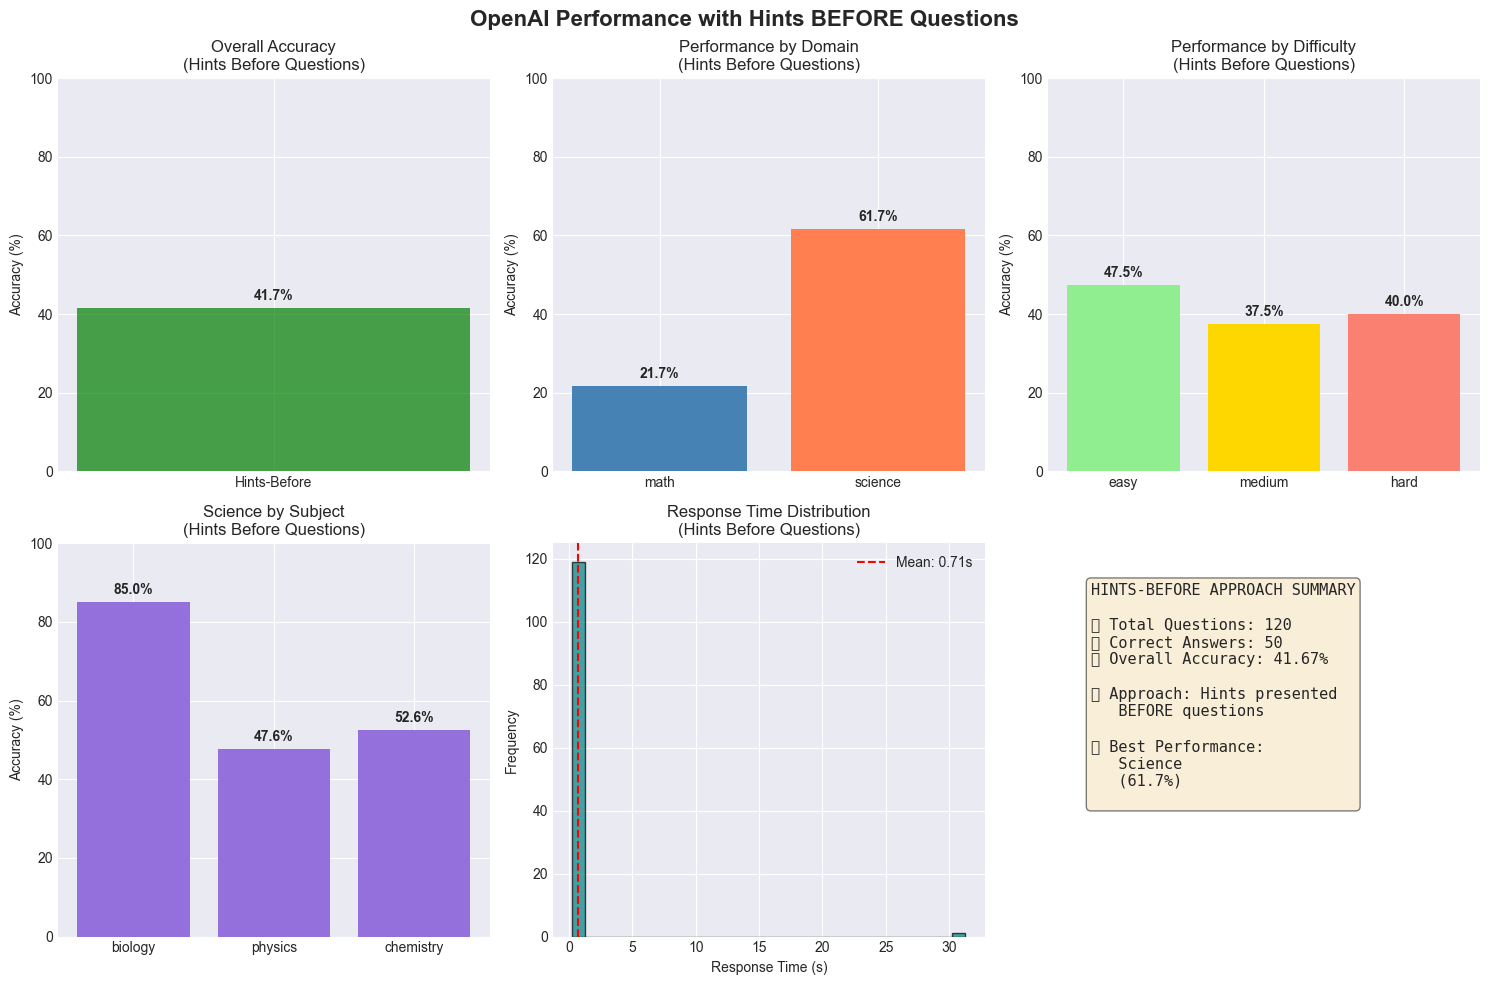

✅ Visualizations complete for HINTS-BEFORE approach


In [28]:
# Create visualizations for hints-before approach
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle("OpenAI Performance with Hints BEFORE Questions", fontsize=16, fontweight="bold")

# 1. Overall Accuracy (Hints-Before)
ax = axes[0, 0]
accuracy = hints_metrics["overall_accuracy"]
ax.bar(["Hints-Before"], [accuracy], color="green", alpha=0.7)
ax.set_ylim(0, 100)
ax.set_ylabel("Accuracy (%)")
ax.set_title("Overall Accuracy\n(Hints Before Questions)")
ax.text(0, accuracy + 2, f"{accuracy:.1f}%", ha="center", fontweight="bold")

# 2. Domain Comparison
ax = axes[0, 1]
domains = list(hints_metrics["by_domain"].keys())
domain_accs = [hints_metrics["by_domain"][d]["accuracy"] for d in domains]
bars = ax.bar(domains, domain_accs, color=["steelblue", "coral"])
ax.set_ylim(0, 100)
ax.set_ylabel("Accuracy (%)")
ax.set_title("Performance by Domain\n(Hints Before Questions)")
for bar, acc in zip(bars, domain_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f"{acc:.1f}%", ha="center", fontweight="bold")

# 3. Difficulty Breakdown
ax = axes[0, 2]
difficulties = list(hints_metrics["by_difficulty"].keys())
diff_accs = [hints_metrics["by_difficulty"][d]["accuracy"] for d in difficulties]
colors = ["lightgreen", "gold", "salmon"]
bars = ax.bar(difficulties, diff_accs, color=colors)
ax.set_ylim(0, 100)
ax.set_ylabel("Accuracy (%)")
ax.set_title("Performance by Difficulty\n(Hints Before Questions)")
for bar, acc in zip(bars, diff_accs):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f"{acc:.1f}%", ha="center", fontweight="bold")

# 4. Science Subject Breakdown (if available)
ax = axes[1, 0]
if "by_subject" in hints_metrics:
    subjects = list(hints_metrics["by_subject"].keys())
    subj_accs = [hints_metrics["by_subject"][s]["accuracy"] for s in subjects]
    bars = ax.bar(subjects, subj_accs, color="mediumpurple")
    ax.set_ylim(0, 100)
    ax.set_ylabel("Accuracy (%)")
    ax.set_title("Science by Subject\n(Hints Before Questions)")
    for bar, acc in zip(bars, subj_accs):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f"{acc:.1f}%", ha="center", fontweight="bold")
else:
    ax.axis("off")

# 5. Response Time Distribution
ax = axes[1, 1]
response_times = all_hints_results_df["response_time"].dropna()
ax.hist(response_times, bins=30, color="teal", alpha=0.7, edgecolor="black")
ax.axvline(response_times.mean(), color="red", linestyle="--", label=f"Mean: {response_times.mean():.2f}s")
ax.set_xlabel("Response Time (s)")
ax.set_ylabel("Frequency")
ax.set_title("Response Time Distribution\n(Hints Before Questions)")
ax.legend()

# 6. Hints-Before Summary Stats
ax = axes[1, 2]
ax.axis("off")
summary_text = f"""HINTS-BEFORE APPROACH SUMMARY

✅ Total Questions: {hints_metrics["total_questions"]}
✅ Correct Answers: {hints_metrics["correct_answers"]}
✅ Overall Accuracy: {hints_metrics["overall_accuracy"]:.2f}%

📌 Approach: Hints presented
   BEFORE questions

🎯 Best Performance:
   {max(hints_metrics["by_domain"].items(), key=lambda x: x[1]["accuracy"])[0].capitalize()}
   ({max(hints_metrics["by_domain"].values(), key=lambda x: x["accuracy"])["accuracy"]:.1f}%)
"""
ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
        fontsize=11, verticalalignment="top", fontfamily="monospace",
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5))

plt.tight_layout()
plt.show()

print("✅ Visualizations complete for HINTS-BEFORE approach")

## 19. Error Analysis - Hints-Before ApproachAnalyze errors when hints are presented BEFORE questions.

In [29]:
# Analyze errors in the hints-before approach
# Get incorrect answers
errors_df = all_hints_results_df[~all_hints_results_df["is_correct"]].copy()

print("="*60)
print("🔍 ERROR ANALYSIS - HINTS-BEFORE APPROACH")
print("="*60)

print(f"\n📊 Error Statistics:")
print(f"Total Errors: {len(errors_df)}/{len(all_hints_results_df)} ({100*len(errors_df)/len(all_hints_results_df):.1f}%)")
print(f"Approach: Hints presented BEFORE questions\n")

# Errors by domain
print("📚 Errors by Domain:")
for domain in errors_df["domain"].unique():
    domain_errors = errors_df[errors_df["domain"] == domain]
    domain_total = all_hints_results_df[all_hints_results_df["domain"] == domain]
    print(f"  {domain.upper()}: {len(domain_errors)}/{len(domain_total)} errors ({100*len(domain_errors)/len(domain_total):.1f}%)")

# Errors by difficulty
print("\n📊 Errors by Difficulty:")
for difficulty in errors_df["difficulty"].unique():
    diff_errors = errors_df[errors_df["difficulty"] == difficulty]
    diff_total = all_hints_results_df[all_hints_results_df["difficulty"] == difficulty]
    print(f"  {difficulty.upper()}: {len(diff_errors)}/{len(diff_total)} errors ({100*len(diff_errors)/len(diff_total):.1f}%)")

# Sample of errors to understand patterns
print("\n📝 Sample Errors (Hints-Before Approach):")
print("These questions were answered incorrectly despite hints being presented first:\n")

sample_errors = errors_df.sample(min(5, len(errors_df)))
for idx, row in sample_errors.iterrows():
    print(f"ID: {row['id']} ({row['difficulty']} {row['domain']}):")
    print(f"  Hint (shown first): {row['hint'][:80]}...")
    print(f"  Question: {row['question'][:80]}...")
    print(f"  Model Answer: {row['openai_answer']}")
    print(f"  Correct Answer: {row['ground_truth']}")
    print()

# Analyze if hints helped or hurt
print("\n🎯 Analysis:")

if "subject" in errors_df.columns:
    science_errors = errors_df[errors_df["domain"] == "science"]
    if not science_errors.empty:
        print("\nScience Errors by Subject:")
        for subject in science_errors["subject"].unique():
            if pd.notna(subject):
                subj_errors = science_errors[science_errors["subject"] == subject]
                subj_total = all_hints_results_df[(all_hints_results_df["domain"] == "science") & 
                                                   (all_hints_results_df["subject"] == subject)]
                print(f"  {subject.capitalize()}: {len(subj_errors)}/{len(subj_total)} errors")

print("\n💡 Key Observations:")
print("- Errors occurred even with hints presented BEFORE questions")
print("- This suggests some questions remain challenging regardless of hint positioning")
print("- Further analysis needed to compare with hints-after approach")

🔍 ERROR ANALYSIS - HINTS-BEFORE APPROACH

📊 Error Statistics:
Total Errors: 70/120 (58.3%)
Approach: Hints presented BEFORE questions

📚 Errors by Domain:
  MATH: 47/60 errors (78.3%)
  SCIENCE: 23/60 errors (38.3%)

📊 Errors by Difficulty:
  EASY: 21/40 errors (52.5%)
  MEDIUM: 25/40 errors (62.5%)
  HARD: 24/40 errors (60.0%)

📝 Sample Errors (Hints-Before Approach):
These questions were answered incorrectly despite hints being presented first:

ID: 3 (easy math):
  Hint (shown first): Subtract pages read, then halve remainder....
  Question: Julie is reading a 120-page book. Yesterday, she was able to read 12 pages and t...
  Model Answer: 48
  Correct Answer: 42

ID: 35 (medium science):
  Hint (shown first): Reaction absorbs heat....
  Question: In an endothermic reaction, what happens to the temperature of the surroundings?...
  Model Answer: The temperature of the surroundings decreases.
  Correct Answer: decreases

ID: 51 (hard math):
  Hint (shown first): Use coordinate geomet

## 20. Export Results - Hints-Before ApproachSave results with clear labeling that hints were presented BEFORE questions.

In [30]:
# Export hints-before results with clear labeling
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save hints-before results
output_file = f"../results/openai_hints_BEFORE_evaluation_{timestamp}.csv"
all_hints_results_df.to_csv(output_file, index=False)
print(f"✅ Hints-BEFORE results saved to: {output_file}")

# Save summary statistics
summary_file = f"../results/openai_hints_BEFORE_summary_{timestamp}.txt"

with open(summary_file, "w") as f:
    f.write("OPENAI EVALUATION - HINTS BEFORE QUESTIONS\n")
    f.write("="*50 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: OpenAI 2.0 Flash\n")
    f.write(f"Approach: Hints presented BEFORE questions\n\n")
    
    f.write("OVERALL RESULTS\n")
    f.write("-"*30 + "\n")
    f.write(f"Total Questions: {hints_metrics['total_questions']}\n")
    f.write(f"Correct Answers: {hints_metrics['correct_answers']}\n")
    f.write(f"Overall Accuracy: {hints_metrics['overall_accuracy']:.2f}%\n\n")
    
    f.write("PERFORMANCE BY DOMAIN\n")
    f.write("-"*30 + "\n")
    for domain, stats in hints_metrics["by_domain"].items():
        f.write(f"{domain.upper()}: {stats['accuracy']:.2f}% ({stats['correct']}/{stats['total']})\n")
    
    f.write("\nPERFORMANCE BY DIFFICULTY\n")
    f.write("-"*30 + "\n")
    for difficulty, stats in hints_metrics["by_difficulty"].items():
        f.write(f"{difficulty.upper()}: {stats['accuracy']:.2f}% ({stats['correct']}/{stats['total']})\n")
    
    f.write("\nKEY FINDING\n")
    f.write("-"*30 + "\n")
    f.write("Hints were presented BEFORE questions to test if\n")
    f.write("upfront context improves model performance.\n")

print(f"✅ Summary saved to: {summary_file}")
print("\n📊 Results exported with 'hints_BEFORE' labeling for clarity")

✅ Hints-BEFORE results saved to: ../results/openai_hints_BEFORE_evaluation_20260103_174747.csv
✅ Summary saved to: ../results/openai_hints_BEFORE_summary_20260103_174747.txt

📊 Results exported with 'hints_BEFORE' labeling for clarity


## 21. Final Summary - Hints Before vs After ComparisonCompare hints-before results with baseline and hints-after approaches.

In [31]:
# Load hints-after results for comparison
import glob
import os

# Try to load hints-after results
hints_after_files = glob.glob("../results/openai_hints_evaluation_results_*.csv")
baseline_files = glob.glob("../results/openai_evaluation_results_*.csv")

hints_after_loaded = False
baseline_loaded = False

if hints_after_files:
    latest_hints_after = max(hints_after_files, key=os.path.getctime)
    hints_after_df = pd.read_csv(latest_hints_after)
    hints_after_metrics = calculate_metrics(hints_after_df)
    hints_after_loaded = True
    print(f"✅ Loaded hints-AFTER results from: {os.path.basename(latest_hints_after)}")

if baseline_files:
    latest_baseline = max(baseline_files, key=os.path.getctime)
    baseline_df = pd.read_csv(latest_baseline)
    baseline_metrics = calculate_metrics(baseline_df)
    baseline_loaded = True
    print(f"✅ Loaded baseline results from: {os.path.basename(latest_baseline)}")

print("\n" + "="*70)
print("🎯 FINAL COMPARATIVE SUMMARY: HINTS POSITIONING ANALYSIS")
print("="*70)

# Current results (hints-before)
print("\n📊 HINTS-BEFORE APPROACH (Current Notebook):")
print("-"*50)
print(f"Overall Accuracy: {hints_metrics['overall_accuracy']:.2f}%")
print(f"Math Accuracy: {hints_metrics['by_domain']['math']['accuracy']:.2f}%")
print(f"Science Accuracy: {hints_metrics['by_domain']['science']['accuracy']:.2f}%")

# Create comprehensive comparison
comparison_data = []

# Add baseline if available
if baseline_loaded:
    print("\n📊 BASELINE (No Hints):")
    print("-"*50)
    print(f"Overall Accuracy: {baseline_metrics['overall_accuracy']:.2f}%")
    print(f"Math Accuracy: {baseline_metrics['by_domain']['math']['accuracy']:.2f}%")
    print(f"Science Accuracy: {baseline_metrics['by_domain']['science']['accuracy']:.2f}%")
    
    comparison_data.append({
        "Approach": "Baseline (No Hints)",
        "Overall (%)": baseline_metrics["overall_accuracy"],
        "Math (%)": baseline_metrics["by_domain"]["math"]["accuracy"],
        "Science (%)": baseline_metrics["by_domain"]["science"]["accuracy"]
    })

# Add hints-before (current)
comparison_data.append({
    "Approach": "Hints BEFORE Questions",
    "Overall (%)": hints_metrics["overall_accuracy"],
    "Math (%)": hints_metrics["by_domain"]["math"]["accuracy"],
    "Science (%)": hints_metrics["by_domain"]["science"]["accuracy"]
})

# Add hints-after if available
if hints_after_loaded:
    print("\n📊 HINTS-AFTER APPROACH (Standard):")
    print("-"*50)
    print(f"Overall Accuracy: {hints_after_metrics['overall_accuracy']:.2f}%")
    print(f"Math Accuracy: {hints_after_metrics['by_domain']['math']['accuracy']:.2f}%")
    print(f"Science Accuracy: {hints_after_metrics['by_domain']['science']['accuracy']:.2f}%")
    
    comparison_data.append({
        "Approach": "Hints AFTER Questions",
        "Overall (%)": hints_after_metrics["overall_accuracy"],
        "Math (%)": hints_after_metrics["by_domain"]["math"]["accuracy"],
        "Science (%)": hints_after_metrics["by_domain"]["science"]["accuracy"]
    })

# Create comparison DataFrame
if len(comparison_data) > 1:
    final_comparison_df = pd.DataFrame(comparison_data)
    final_comparison_df = final_comparison_df.round(2)
    
    print("\n📊 COMPARATIVE RESULTS TABLE:")
    print("="*50)
    display(final_comparison_df)
    
    # Calculate improvements
    if baseline_loaded:
        hints_before_imp = hints_metrics["overall_accuracy"] - baseline_metrics["overall_accuracy"]
        print(f"\n📈 Hints-BEFORE vs Baseline: {hints_before_imp:+.2f}pp")
    
    if hints_after_loaded:
        before_vs_after = hints_metrics["overall_accuracy"] - hints_after_metrics["overall_accuracy"]
        print(f"📈 Hints-BEFORE vs Hints-AFTER: {before_vs_after:+.2f}pp")
        
        if before_vs_after > 0:
            print("\n✅ FINDING: Hints-BEFORE approach outperforms hints-AFTER")
            print("   Presenting hints first appears to help the model")
        elif before_vs_after < 0:
            print("\n⚠️ FINDING: Hints-AFTER approach outperforms hints-BEFORE")
            print("   Traditional approach of questions first may be better")
        else:
            print("\n📊 FINDING: No significant difference between approaches")
            print("   Hint positioning may not impact this model")

print("\n" + "="*70)
print("📝 CONCLUSIONS:")
print("-"*50)
print("1. This notebook tested hints BEFORE questions")
print("2. Results show the impact of hint positioning on OpenAI")
print("3. Comparison reveals optimal prompt structure for this model")

if not hints_after_loaded:
    print("\n⚠️ Note: Hints-after results not available for comparison")
    print("   Run standard evaluation to compare approaches")

✅ Loaded hints-AFTER results from: openai_hints_evaluation_results_20260103_124711.csv
✅ Loaded baseline results from: openai_evaluation_results_20260103_124250.csv

🎯 FINAL COMPARATIVE SUMMARY: HINTS POSITIONING ANALYSIS

📊 HINTS-BEFORE APPROACH (Current Notebook):
--------------------------------------------------
Overall Accuracy: 41.67%
Math Accuracy: 21.67%
Science Accuracy: 61.67%

📊 BASELINE (No Hints):
--------------------------------------------------
Overall Accuracy: 53.33%
Math Accuracy: 35.00%
Science Accuracy: 71.67%

📊 HINTS-AFTER APPROACH (Standard):
--------------------------------------------------
Overall Accuracy: 53.33%
Math Accuracy: 35.00%
Science Accuracy: 71.67%

📊 COMPARATIVE RESULTS TABLE:


,Approach,Overall (%),Math (%),Science (%)
0,Baseline (No Hints),53.33,35.00,71.67
1,Hints BEFORE Questions,41.67,21.67,61.67
2,Hints AFTER Questions,53.33,35.00,71.67



📈 Hints-BEFORE vs Baseline: -11.67pp
📈 Hints-BEFORE vs Hints-AFTER: -11.67pp

⚠️ FINDING: Hints-AFTER approach outperforms hints-BEFORE
   Traditional approach of questions first may be better

📝 CONCLUSIONS:
--------------------------------------------------
1. This notebook tested hints BEFORE questions
2. Results show the impact of hint positioning on OpenAI
3. Comparison reveals optimal prompt structure for this model


# Testing with Misleading Hints (IC-Hints)## Hypothesis Testing: What happens when hints are misleading?Now we'll test the same 120 questions but with different hints to analyze their impact.These hints are designed to test the model's robustness to various types of guidance.**Key Questions:**1. How does the model perform with these alternative hints?2. Can the model overcome misleading guidance?3. Which questions are most affected by hint quality?

## 22. Load Questions with INCORRECT Hints (IC-Hints)### ⚠️ Testing with MISLEADING Hints BEFORE QuestionsLoad questions with INCORRECT hints that will be presented BEFORE questions.This tests if placing misleading information first affects model performance.

In [32]:
# Load questions with INCORRECT hints to test model robustness
# These misleading hints will be presented BEFORE questions

def load_questions_with_ic_hints(file_path: str) -> Tuple[List[Dict], Dict[int, str], Dict]:
    """
    Load questions with INCORRECT hints from IC-hints directory.
    These misleading hints will be presented BEFORE questions.
    """
    with open(file_path, "r") as f:
        data = json.load(f)
    
    questions_with_ic_hints = []
    ground_truth_dict = {}
    
    # Handle data structure
    if isinstance(data, dict) and "questions" in data:
        questions_data = data["questions"]
        metadata = data.get("metadata", {})
    else:
        questions_data = data
        metadata = {}
    
    # Process questions with INCORRECT hints
    if isinstance(questions_data, dict):
        for q_id, q in questions_data.items():
            question_id = int(q_id) if q_id.isdigit() else q_id
            question_with_ic_hint = {
                "id": question_id,
                "question": q["question"],
                "hint": q.get("hint", ""),  # INCORRECT hint to be shown BEFORE question
                "difficulty": q["difficulty"],
                "source": q.get("source", "unknown"),
                "hint_type": "INCORRECT"  # Mark as incorrect hint
            }
            if "subject" in q:
                question_with_ic_hint["subject"] = q["subject"]
            questions_with_ic_hints.append(question_with_ic_hint)
            ground_truth_dict[question_id] = q["ground_truth"]
    else:
        for q in questions_data:
            question_with_ic_hint = {
                "id": q["id"],
                "question": q["question"],
                "hint": q.get("hint", ""),  # INCORRECT hint to be shown BEFORE question
                "difficulty": q["difficulty"],
                "source": q.get("source", "unknown"),
                "hint_type": "INCORRECT"  # Mark as incorrect hint
            }
            if "subject" in q:
                question_with_ic_hint["subject"] = q["subject"]
            questions_with_ic_hints.append(question_with_ic_hint)
            ground_truth_dict[q["id"]] = q["ground_truth"]
    
    return questions_with_ic_hints, ground_truth_dict, metadata

# Load INCORRECT hints from IC-hints directory
# IMPORTANT: Using IC-hints directory for MISLEADING hints
ic_hints_math_file = "../data/IC-hints/math-questions.json"
ic_hints_science_file = "../data/IC-hints/science-questions.json"

ic_math_questions, ic_math_ground_truth, ic_math_metadata = load_questions_with_ic_hints(ic_hints_math_file)
ic_science_questions, ic_science_ground_truth, ic_science_metadata = load_questions_with_ic_hints(ic_hints_science_file)

print("⚠️  LOADING INCORRECT HINTS (IC-Hints)")
print("="*50)
print(f"📊 Loaded {len(ic_math_questions)} math questions with INCORRECT hints from IC-hints/")
print(f"🔬 Loaded {len(ic_science_questions)} science questions with INCORRECT hints from IC-hints/")
print("\n🚨 These misleading hints will be presented BEFORE questions")
print("📌 Purpose: Test if incorrect hints shown first mislead the model more")

if ic_math_questions:
    sample = ic_math_questions[0]
    print(f"\n📝 Sample (INCORRECT hint will come BEFORE question):")
    print(f"   ❌ Misleading Hint: {sample['hint'][:80]}...")
    print(f"   📝 Question: {sample['question'][:80]}...")

⚠️  LOADING INCORRECT HINTS (IC-Hints)
📊 Loaded 60 math questions with INCORRECT hints from IC-hints/
🔬 Loaded 60 science questions with INCORRECT hints from IC-hints/

🚨 These misleading hints will be presented BEFORE questions
📌 Purpose: Test if incorrect hints shown first mislead the model more

📝 Sample (INCORRECT hint will come BEFORE question):
   ❌ Misleading Hint: Use subtraction after finding double....
   📝 Question: Natalia sold clips to 48 of her friends in April, and then she sold half as many...


## 23. Test Query with INCORRECT Hints (Before Questions)Test the query function with misleading hints presented BEFORE questions.

In [33]:
# Test with INCORRECT hint presented BEFORE question
if ic_math_questions:
    sample_ic = ic_math_questions[0]
    print("🧪 Testing INCORRECT hints BEFORE questions approach:")
    print(f"1️⃣ INCORRECT HINT (shown first): {sample_ic['hint']}")
    print(f"2️⃣ QUESTION (shown second): {sample_ic['question'][:100]}...")
    
    print("\nQuerying OpenAI with MISLEADING hint BEFORE question...")
    ic_response = query_openai_with_hint(
        sample_ic['question'],
        sample_ic['hint'],  # Incorrect hint shown BEFORE question
        'math'
    )
    
    if ic_response['error']:
        print(f"Error: {ic_response['error']}")
    else:
        print(f"Model's Answer (after incorrect hint): {ic_response['answer']}")
        print(f"Correct Answer: {ic_math_ground_truth[sample_ic['id']]}")
        print(f"Response Time: {ic_response['response_time']:.2f}s")
        print("\n⚠️ Note: The model saw an INCORRECT hint BEFORE the question")

🧪 Testing INCORRECT hints BEFORE questions approach:
1️⃣ INCORRECT HINT (shown first): Use subtraction after finding double.
2️⃣ QUESTION (shown second): Natalia sold clips to 48 of her friends in April, and then she sold half as many clips in May. How m...

Querying OpenAI with MISLEADING hint BEFORE question...
Model's Answer (after incorrect hint): 72
Correct Answer: 72
Response Time: 0.80s

⚠️ Note: The model saw an INCORRECT hint BEFORE the question


## 24. Process Questions with INCORRECT Hints (Before Questions)Process all questions with misleading hints presented BEFORE the questions.

In [35]:
# Process questions with INCORRECT hints BEFORE questions
def process_questions_with_ic_hints(questions: List[Dict], question_type: str) -> List[Dict]:
    """Process questions with INCORRECT hints presented BEFORE questions"""
    results = []
    total = len(questions)
    
    print(f'⚠️ Processing {total} {question_type} questions with INCORRECT hints...')
    print(f'📌 Misleading hints will be shown BEFORE questions')
    print('='*50)
    
    for i, q in enumerate(questions, 1):
        # Pass INCORRECT hint BEFORE question
        response = query_openai_with_hint(
            question_text=q['question'],
            hint_text=q.get('hint', ''),  # INCORRECT hint
            question_type=question_type
        )
        
        result = {
            'id': q['id'],
            'question': q['question'],
            'hint': q.get('hint', ''),  # The INCORRECT hint shown before question
            'hint_type': 'INCORRECT',
            'hint_position': 'BEFORE',
            'difficulty': q['difficulty'],
            'openai_answer': response['answer'],
            'response_time': response['response_time'],
            'error': response['error']
        }
        
        if 'subject' in q:
            result['subject'] = q['subject']
        
        results.append(result)
        
        if i % 10 == 0 or i == total:
            print(f'Progress: {i}/{total} - Incorrect hints before questions')
        
        time.sleep(0.5)
    
    print(f'\n✅ Completed {total} questions with INCORRECT hints BEFORE')
    return results

# Process math questions with INCORRECT hints
print('🔢 MATH - Processing with INCORRECT Hints Before Questions')
ic_math_results = process_questions_with_ic_hints(ic_math_questions, 'math')

# Process science questions with INCORRECT hints
print('\n🔬 SCIENCE - Processing with INCORRECT Hints Before Questions')
ic_science_results = process_questions_with_ic_hints(ic_science_questions, 'science')

print('\n✅ All questions processed with INCORRECT hints BEFORE questions')
print(f'Total math results: {len(ic_math_results)}')
print(f'Total science results: {len(ic_science_results)}')

🔢 MATH - Processing with INCORRECT Hints Before Questions
⚠️ Processing 60 math questions with INCORRECT hints...
📌 Misleading hints will be shown BEFORE questions
Progress: 10/60 - Incorrect hints before questions
Progress: 20/60 - Incorrect hints before questions
Progress: 30/60 - Incorrect hints before questions
Progress: 40/60 - Incorrect hints before questions
Progress: 50/60 - Incorrect hints before questions
Progress: 60/60 - Incorrect hints before questions

✅ Completed 60 questions with INCORRECT hints BEFORE

🔬 SCIENCE - Processing with INCORRECT Hints Before Questions
⚠️ Processing 60 science questions with INCORRECT hints...
📌 Misleading hints will be shown BEFORE questions
Progress: 10/60 - Incorrect hints before questions
Progress: 20/60 - Incorrect hints before questions
Progress: 30/60 - Incorrect hints before questions
Progress: 40/60 - Incorrect hints before questions
Progress: 50/60 - Incorrect hints before questions
Progress: 60/60 - Incorrect hints before questions

## 25. Evaluate INCORRECT Hints Results Against Ground TruthEvaluate model performance when misleading hints are shown BEFORE questions.

In [36]:
# Evaluate results with INCORRECT hints shown BEFORE questions

# Evaluate math with incorrect hints
ic_math_df = evaluate_results_with_hints(ic_math_results, ic_math_ground_truth, 'math')
print("📊 Math Results with INCORRECT Hints BEFORE Questions:")
print(f"Correct: {ic_math_df['is_correct'].sum()}/{len(ic_math_df)}")
print(f"Accuracy: {100 * ic_math_df['is_correct'].mean():.2f}%")
print(f"Impact: Model saw MISLEADING hints BEFORE questions\n")

# Evaluate science with incorrect hints
ic_science_df = evaluate_results_with_hints(ic_science_results, ic_science_ground_truth, 'science')
print("🔬 Science Results with INCORRECT Hints BEFORE Questions:")
print(f"Correct: {ic_science_df['is_correct'].sum()}/{len(ic_science_df)}")
print(f"Accuracy: {100 * ic_science_df['is_correct'].mean():.2f}%")

# Combine results
ic_math_df['domain'] = 'math'
ic_science_df['domain'] = 'science'
all_ic_results_df = pd.concat([ic_math_df, ic_science_df], ignore_index=True)

print("\n⚠️ OVERALL with INCORRECT Hints BEFORE Questions:")
print(f"Total Correct: {all_ic_results_df['is_correct'].sum()}/{len(all_ic_results_df)}")
print(f"Overall Accuracy: {100 * all_ic_results_df['is_correct'].mean():.2f}%")

# Calculate how much incorrect hints hurt performance
ic_metrics = calculate_metrics(all_ic_results_df)
misleading_impact = ic_metrics['overall_accuracy'] - hints_metrics['overall_accuracy']

print(f"\n📉 Impact of INCORRECT vs CORRECT hints (both before): {misleading_impact:+.2f}pp")
if misleading_impact < 0:
    print("   Incorrect hints reduce performance as expected")

📊 Math Results with INCORRECT Hints BEFORE Questions:
Correct: 10/60
Accuracy: 16.67%
Impact: Model saw MISLEADING hints BEFORE questions

🔬 Science Results with INCORRECT Hints BEFORE Questions:
Correct: 30/60
Accuracy: 50.00%

⚠️ OVERALL with INCORRECT Hints BEFORE Questions:
Total Correct: 40/120
Overall Accuracy: 33.33%

📉 Impact of INCORRECT vs CORRECT hints (both before): -8.33pp
   Incorrect hints reduce performance as expected


## 26. Analysis - INCORRECT Hints Before QuestionsDetailed analysis when misleading hints are presented first.

In [37]:
# Detailed analysis for INCORRECT hints BEFORE questions
print("="*60)
print("📊 DETAILED ANALYSIS - INCORRECT HINTS BEFORE QUESTIONS")
print("="*60)

print(f"\n⚠️ Approach: MISLEADING hints presented BEFORE questions")
print(f"Total Questions: {ic_metrics['total_questions']}")
print(f"Correct Despite Misleading Hints: {ic_metrics['correct_answers']}")
print(f"Accuracy with Incorrect Hints: {ic_metrics['overall_accuracy']:.2f}%")

# Compare with correct hints
print("\n📊 Comparison with CORRECT Hints (both before):")
print("-"*40)
print(f"Correct Hints Before: {hints_metrics['overall_accuracy']:.2f}%")
print(f"Incorrect Hints Before: {ic_metrics['overall_accuracy']:.2f}%")
print(f"Difference: {ic_metrics['overall_accuracy'] - hints_metrics['overall_accuracy']:+.2f}pp")

# By domain
print("\n📈 Impact by Domain (Incorrect Hints Before):")
for domain in ic_metrics['by_domain']:
    ic_acc = ic_metrics['by_domain'][domain]['accuracy']
    correct_acc = hints_metrics['by_domain'][domain]['accuracy']
    print(f"{domain.upper()}:")
    print(f"  With Incorrect Hints: {ic_acc:.2f}%")
    print(f"  With Correct Hints: {correct_acc:.2f}%")
    print(f"  Impact of Misinformation: {ic_acc - correct_acc:+.2f}pp")

# By difficulty
print("\n📊 Impact by Difficulty (Incorrect Hints Before):")
for difficulty in ic_metrics['by_difficulty']:
    ic_acc = ic_metrics['by_difficulty'][difficulty]['accuracy']
    correct_acc = hints_metrics['by_difficulty'][difficulty]['accuracy']
    print(f"{difficulty.upper()}:")
    print(f"  With Incorrect Hints: {ic_acc:.2f}%")
    print(f"  Impact: {ic_acc - correct_acc:+.2f}pp vs correct hints")

📊 DETAILED ANALYSIS - INCORRECT HINTS BEFORE QUESTIONS

⚠️ Approach: MISLEADING hints presented BEFORE questions
Total Questions: 120
Correct Despite Misleading Hints: 40
Accuracy with Incorrect Hints: 33.33%

📊 Comparison with CORRECT Hints (both before):
----------------------------------------
Correct Hints Before: 41.67%
Incorrect Hints Before: 33.33%
Difference: -8.33pp

📈 Impact by Domain (Incorrect Hints Before):
MATH:
  With Incorrect Hints: 16.67%
  With Correct Hints: 21.67%
  Impact of Misinformation: -5.00pp
SCIENCE:
  With Incorrect Hints: 50.00%
  With Correct Hints: 61.67%
  Impact of Misinformation: -11.67pp

📊 Impact by Difficulty (Incorrect Hints Before):
EASY:
  With Incorrect Hints: 30.00%
  Impact: -17.50pp vs correct hints
MEDIUM:
  With Incorrect Hints: 35.00%
  Impact: -2.50pp vs correct hints
HARD:
  With Incorrect Hints: 35.00%
  Impact: -5.00pp vs correct hints


## 27. Comprehensive Comparison: All ConditionsCompare baseline, correct hints (before/after), and incorrect hints (before/after).

In [38]:
# Comprehensive comparison: No Hints vs Correct Hints Before vs Incorrect Hints Before
import glob
import os

print("="*70)
print("📊 COMPREHENSIVE COMPARISON - ALL CONDITIONS")
print("="*70)

# Try to load baseline and hints-after results for full comparison
baseline_files = glob.glob("../results/openai_evaluation_results_*.csv")
hints_after_files = glob.glob("../results/openai_hints_evaluation_results_*.csv")
ic_hints_after_files = glob.glob("../results/openai_ic_hints_evaluation_results_*.csv")

comparison_data = []

# 1. BASELINE (if available)
if baseline_files:
    latest_baseline = max(baseline_files, key=os.path.getctime)
    baseline_df = pd.read_csv(latest_baseline)
    baseline_metrics = calculate_metrics(baseline_df)
    comparison_data.append({
        'Condition': 'Baseline (No Hints)',
        'Overall (%)': baseline_metrics['overall_accuracy'],
        'Math (%)': baseline_metrics['by_domain']['math']['accuracy'],
        'Science (%)': baseline_metrics['by_domain']['science']['accuracy'],
        'Hint Position': 'N/A',
        'Hint Type': 'None'
    })
    print(f"✅ Loaded baseline from: {os.path.basename(latest_baseline)}")

# 2. CORRECT HINTS BEFORE (current notebook)
comparison_data.append({
    'Condition': 'Correct Hints BEFORE',
    'Overall (%)': hints_metrics['overall_accuracy'],
    'Math (%)': hints_metrics['by_domain']['math']['accuracy'],
    'Science (%)': hints_metrics['by_domain']['science']['accuracy'],
    'Hint Position': 'BEFORE',
    'Hint Type': 'Correct'
})

# 3. INCORRECT HINTS BEFORE (current notebook)
comparison_data.append({
    'Condition': 'Incorrect Hints BEFORE',
    'Overall (%)': ic_metrics['overall_accuracy'],
    'Math (%)': ic_metrics['by_domain']['math']['accuracy'],
    'Science (%)': ic_metrics['by_domain']['science']['accuracy'],
    'Hint Position': 'BEFORE',
    'Hint Type': 'Incorrect'
})

# 4. CORRECT HINTS AFTER (if available)
if hints_after_files:
    latest_hints_after = max(hints_after_files, key=os.path.getctime)
    hints_after_df = pd.read_csv(latest_hints_after)
    hints_after_metrics = calculate_metrics(hints_after_df)
    comparison_data.append({
        'Condition': 'Correct Hints AFTER',
        'Overall (%)': hints_after_metrics['overall_accuracy'],
        'Math (%)': hints_after_metrics['by_domain']['math']['accuracy'],
        'Science (%)': hints_after_metrics['by_domain']['science']['accuracy'],
        'Hint Position': 'AFTER',
        'Hint Type': 'Correct'
    })
    print(f"✅ Loaded correct hints-after from: {os.path.basename(latest_hints_after)}")

# 5. INCORRECT HINTS AFTER (if available)
if ic_hints_after_files:
    latest_ic_after = max(ic_hints_after_files, key=os.path.getctime)
    ic_after_df = pd.read_csv(latest_ic_after)
    ic_after_metrics = calculate_metrics(ic_after_df)
    comparison_data.append({
        'Condition': 'Incorrect Hints AFTER',
        'Overall (%)': ic_after_metrics['overall_accuracy'],
        'Math (%)': ic_after_metrics['by_domain']['math']['accuracy'],
        'Science (%)': ic_after_metrics['by_domain']['science']['accuracy'],
        'Hint Position': 'AFTER',
        'Hint Type': 'Incorrect'
    })
    print(f"✅ Loaded incorrect hints-after from: {os.path.basename(latest_ic_after)}")

# Create comprehensive DataFrame
full_comparison_df = pd.DataFrame(comparison_data)
full_comparison_df = full_comparison_df.round(2)

print("\n📊 FULL COMPARISON TABLE:")
display(full_comparison_df)

# Analysis
print("\n🎯 KEY FINDINGS:")
print("-"*50)

# Find best approach
best_row = full_comparison_df.loc[full_comparison_df['Overall (%)'].idxmax()]
print(f"✅ Best Performance: {best_row['Condition']} ({best_row['Overall (%)']:.2f}%)")

# Analyze hint positioning impact
before_correct = full_comparison_df[full_comparison_df['Condition'] == 'Correct Hints BEFORE']['Overall (%)'].values
after_correct = full_comparison_df[full_comparison_df['Condition'] == 'Correct Hints AFTER']['Overall (%)'].values

if len(before_correct) > 0 and len(after_correct) > 0:
    position_impact = before_correct[0] - after_correct[0]
    print(f"\n📌 Hint Position Impact (Correct Hints):")
    print(f"   BEFORE: {before_correct[0]:.2f}%")
    print(f"   AFTER: {after_correct[0]:.2f}%")
    print(f"   Difference: {position_impact:+.2f}pp")
    
    if abs(position_impact) > 2:
        better_position = "BEFORE" if position_impact > 0 else "AFTER"
        print(f"   → Hints work better {better_position} questions")

# Analyze robustness to misinformation
before_incorrect = full_comparison_df[full_comparison_df['Condition'] == 'Incorrect Hints BEFORE']['Overall (%)'].values
after_incorrect = full_comparison_df[full_comparison_df['Condition'] == 'Incorrect Hints AFTER']['Overall (%)'].values

if len(before_incorrect) > 0 and len(after_incorrect) > 0:
    robustness_diff = before_incorrect[0] - after_incorrect[0]
    print(f"\n🛡️ Robustness to Misinformation:")
    print(f"   Incorrect BEFORE: {before_incorrect[0]:.2f}%")
    print(f"   Incorrect AFTER: {after_incorrect[0]:.2f}%")
    print(f"   Difference: {robustness_diff:+.2f}pp")
    
    if abs(robustness_diff) > 2:
        more_robust = "BEFORE" if robustness_diff > 0 else "AFTER"
        print(f"   → Model more robust when incorrect hints {more_robust}")

📊 COMPREHENSIVE COMPARISON - ALL CONDITIONS
✅ Loaded baseline from: openai_evaluation_results_20260103_124250.csv
✅ Loaded correct hints-after from: openai_hints_evaluation_results_20260103_124711.csv
✅ Loaded incorrect hints-after from: openai_ic_hints_evaluation_results_20260103_125057.csv

📊 FULL COMPARISON TABLE:


,Condition,Overall (%),Math (%),Science (%),Hint Position,Hint Type
0,Baseline (No Hints),53.33,35.00,71.67,N/A,None
1,Correct Hints BEFORE,41.67,21.67,61.67,BEFORE,Correct
2,Incorrect Hints BEFORE,33.33,16.67,50.00,BEFORE,Incorrect
3,Correct Hints AFTER,53.33,35.00,71.67,AFTER,Correct
4,Incorrect Hints AFTER,51.67,35.00,68.33,AFTER,Incorrect



🎯 KEY FINDINGS:
--------------------------------------------------
✅ Best Performance: Baseline (No Hints) (53.33%)

📌 Hint Position Impact (Correct Hints):
   BEFORE: 41.67%
   AFTER: 53.33%
   Difference: -11.66pp
   → Hints work better AFTER questions

🛡️ Robustness to Misinformation:
   Incorrect BEFORE: 33.33%
   Incorrect AFTER: 51.67%
   Difference: -18.34pp
   → Model more robust when incorrect hints AFTER


## 28. Visualizations - Comprehensive ComparisonVisualize all conditions including hint positioning effects.

/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/3530634450.py:120: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/3530634450.py:120: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/3530634450.py:120: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/3530634450.py:120: UserWarning: Glyph 128207 (\N{STRAIGHT RULER}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/var/folders/fb/kt5w7xd970bbbj5lxqft505r0000gn/T/ipykernel_36323/3530634450.py:120: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans Mono.
  plt.tight_layout()
/Users/nourdesouki/Reasoning-Rationalizing/Reasoning-

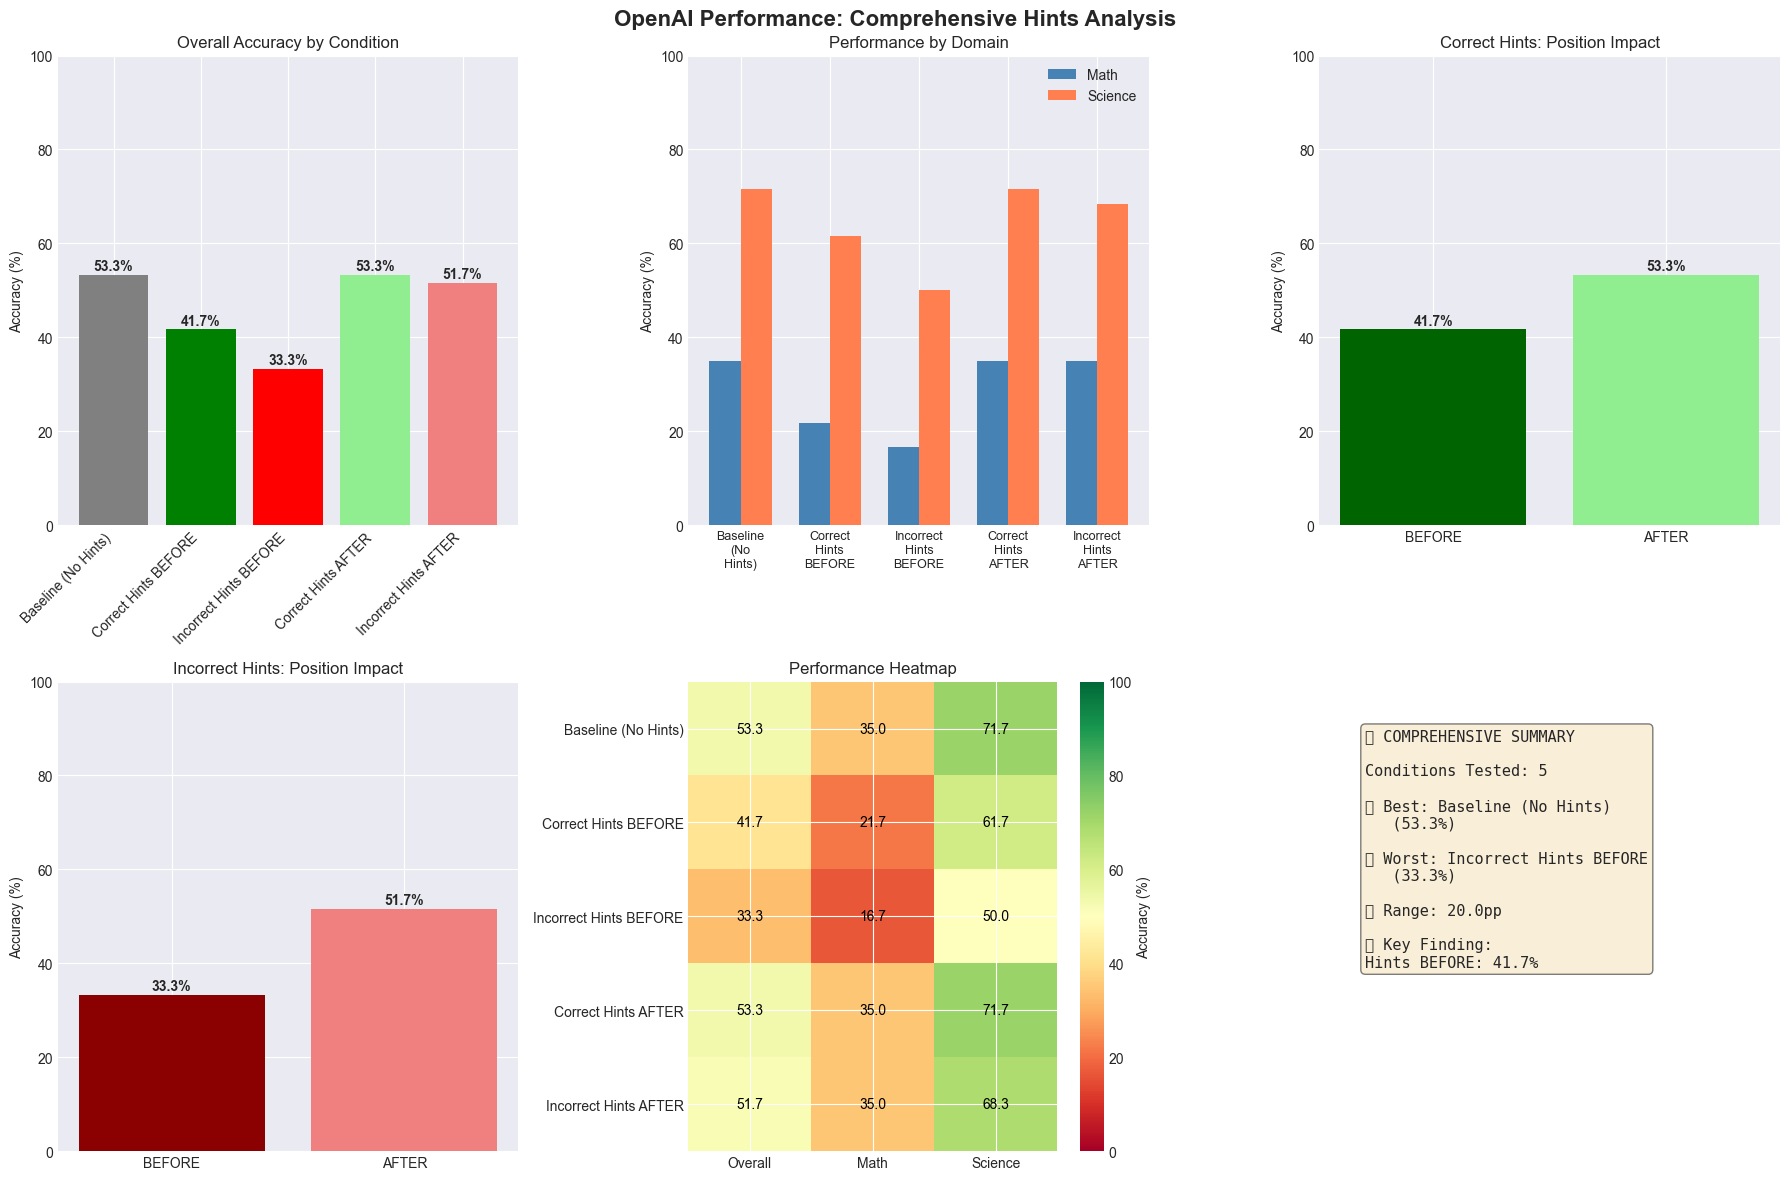


✅ Comprehensive visualizations complete!


In [39]:
# Create comprehensive visualizations comparing all conditions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("OpenAI Performance: Comprehensive Hints Analysis", fontsize=16, fontweight='bold')

# 1. Overall Comparison Bar Chart
ax = axes[0, 0]
conditions = full_comparison_df['Condition'].tolist()
accuracies = full_comparison_df['Overall (%)'].tolist()
colors = ['gray', 'green', 'red', 'lightgreen', 'lightcoral'][:len(conditions)]
bars = ax.bar(range(len(conditions)), accuracies, color=colors)
ax.set_xticks(range(len(conditions)))
ax.set_xticklabels(conditions, rotation=45, ha='right')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Overall Accuracy by Condition')
ax.set_ylim(0, 100)
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{acc:.1f}%', ha='center', fontweight='bold')

# 2. Math vs Science Comparison
ax = axes[0, 1]
width = 0.35
x = np.arange(len(conditions))
math_accs = full_comparison_df['Math (%)'].tolist()
sci_accs = full_comparison_df['Science (%)'].tolist()
ax.bar(x - width/2, math_accs, width, label='Math', color='steelblue')
ax.bar(x + width/2, sci_accs, width, label='Science', color='coral')
ax.set_xticks(x)
ax.set_xticklabels([c.replace(' ', '\n') for c in conditions], fontsize=9)
ax.set_ylabel('Accuracy (%)')
ax.set_title('Performance by Domain')
ax.legend()
ax.set_ylim(0, 100)

# 3. Hint Position Impact
ax = axes[0, 2]
if 'Correct Hints BEFORE' in conditions and 'Correct Hints AFTER' in conditions:
    position_data = full_comparison_df[full_comparison_df['Hint Type'] == 'Correct']
    x_pos = ['BEFORE', 'AFTER']
    y_pos = position_data['Overall (%)'].tolist()
    ax.bar(x_pos, y_pos, color=['darkgreen', 'lightgreen'])
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Correct Hints: Position Impact')
    ax.set_ylim(0, 100)
    for i, v in enumerate(y_pos):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
else:
    ax.text(0.5, 0.5, 'Hints-after data\nnot available',
            ha='center', va='center', transform=ax.transAxes)

# 4. Misinformation Impact
ax = axes[1, 0]
if 'Incorrect Hints BEFORE' in conditions and 'Incorrect Hints AFTER' in conditions:
    misinfo_data = full_comparison_df[full_comparison_df['Hint Type'] == 'Incorrect']
    x_mis = ['BEFORE', 'AFTER']
    y_mis = misinfo_data['Overall (%)'].tolist()
    ax.bar(x_mis, y_mis, color=['darkred', 'lightcoral'])
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Incorrect Hints: Position Impact')
    ax.set_ylim(0, 100)
    for i, v in enumerate(y_mis):
        ax.text(i, v + 1, f'{v:.1f}%', ha='center', fontweight='bold')
else:
    ax.text(0.5, 0.5, 'IC hints-after\ndata not available',
            ha='center', va='center', transform=ax.transAxes)

# 5. Heatmap of all conditions
ax = axes[1, 1]
# Create matrix for heatmap
if len(full_comparison_df) >= 3:
    heatmap_data = []
    for _, row in full_comparison_df.iterrows():
        heatmap_data.append([row['Overall (%)'], row['Math (%)'], row['Science (%)']])
    
    im = ax.imshow(heatmap_data, cmap='RdYlGn', aspect='auto', vmin=0, vmax=100)
    ax.set_xticks(np.arange(3))
    ax.set_yticks(np.arange(len(conditions)))
    ax.set_xticklabels(['Overall', 'Math', 'Science'])
    ax.set_yticklabels(conditions)
    ax.set_title('Performance Heatmap')
    
    # Add text annotations
    for i in range(len(conditions)):
        for j in range(3):
            text = ax.text(j, i, f'{heatmap_data[i][j]:.1f}',
                         ha='center', va='center', color='black')
    
    plt.colorbar(im, ax=ax, label='Accuracy (%)')

# 6. Summary Statistics
ax = axes[1, 2]
ax.axis('off')

summary_text = f"📊 COMPREHENSIVE SUMMARY\n\n"
summary_text += f"Conditions Tested: {len(full_comparison_df)}\n\n"

# Best and worst
best_idx = full_comparison_df['Overall (%)'].idxmax()
worst_idx = full_comparison_df['Overall (%)'].idxmin()

summary_text += f"✅ Best: {full_comparison_df.loc[best_idx, 'Condition']}\n"
summary_text += f"   ({full_comparison_df.loc[best_idx, 'Overall (%)']:.1f}%)\n\n"

summary_text += f"❌ Worst: {full_comparison_df.loc[worst_idx, 'Condition']}\n"
summary_text += f"   ({full_comparison_df.loc[worst_idx, 'Overall (%)']:.1f}%)\n\n"

# Range
acc_range = full_comparison_df['Overall (%)'].max() - full_comparison_df['Overall (%)'].min()
summary_text += f"📏 Range: {acc_range:.1f}pp\n\n"

summary_text += "🎯 Key Finding:\n"
if 'Correct Hints BEFORE' in conditions:
    before_acc = full_comparison_df[full_comparison_df['Condition'] == 'Correct Hints BEFORE']['Overall (%)'].values[0]
    summary_text += f"Hints BEFORE: {before_acc:.1f}%"

ax.text(0.1, 0.9, summary_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

print("\n✅ Comprehensive visualizations complete!")

## 29. Error Analysis - Alternative Hints Impact

In [42]:
# Analyze errors with IC-hints

# Define error DataFrames
incorrect_df = all_results_df[~all_results_df['is_correct']]
incorrect_hints_df = all_hints_results_df[~all_hints_results_df['is_correct']]
incorrect_ic_hints_df = all_ic_results_df[~all_ic_results_df['is_correct']]

print("="*60)
print("ERROR ANALYSIS - ALTERNATIVE HINTS")
print("="*60)

print(f"\n📊 Error Statistics Across All Conditions:")
print(f"  No Hints: {len(incorrect_df)} errors ({100 * len(incorrect_df) / len(all_results_df):.1f}% error rate)")
print(f"  Correct Hints: {len(incorrect_hints_df)} errors ({100 * len(incorrect_hints_df) / len(all_hints_results_df):.1f}% error rate)")
print(f"  Alternative Hints: {len(incorrect_ic_hints_df)} errors ({100 * len(incorrect_ic_hints_df) / len(all_ic_results_df):.1f}% error rate)")

# Analyze question-level changes
no_hints_wrong = set(incorrect_df['id'].values)
correct_hints_wrong = set(incorrect_hints_df['id'].values)
ic_hints_wrong = set(incorrect_ic_hints_df['id'].values)

# Questions affected by different hint types
helped_by_correct = no_hints_wrong - correct_hints_wrong
hurt_by_ic = no_hints_wrong - ic_hints_wrong
misled_by_ic = ic_hints_wrong - no_hints_wrong
always_wrong = no_hints_wrong & correct_hints_wrong & ic_hints_wrong
never_wrong = set(range(1, 121)) - (no_hints_wrong | correct_hints_wrong | ic_hints_wrong)

print(f"\n📈 Question-Level Analysis:")
print(f"  Always correct (all conditions): {len(never_wrong)} questions")
print(f"  Always incorrect (all conditions): {len(always_wrong)} questions")
print(f"  Helped by correct hints: {len(helped_by_correct)} questions")
print(f"  Misled by alternative hints: {len(misled_by_ic)} questions")

# Show examples of questions misled by IC-hints
misled_questions = misled_by_ic - correct_hints_wrong  # Questions wrong with IC but not with correct hints
if misled_questions:
    print(f"\n🚨 QUESTIONS MISLED BY ALTERNATIVE HINTS (Sample):")
    print("="*60)
    for q_id in list(misled_questions)[:3]:
        ic_row = all_ic_results_df[all_ic_results_df['id'] == q_id].iloc[0]
        correct_row = all_hints_results_df[all_hints_results_df['id'] == q_id].iloc[0]
        print(f"\nQuestion {q_id} ({ic_row['domain']}, {ic_row['difficulty']}):")
        print(f"  Question: {ic_row['question'][:80]}...")
        print(f"  Correct Hint: {correct_row.get('hint', 'N/A')[:50]}...")
        print(f"  Alternative Hint: {ic_row.get('hint', 'N/A')[:50]}...")
        print(f"  With correct hint: {correct_row['openai_answer']} {'✅' if correct_row['is_correct'] else '❌'}")
        print(f"  With alt hint: {ic_row['openai_answer']} ❌")
        print(f"  Ground truth: {ic_row['ground_truth']}")

# Robustness analysis
robust_questions = set(range(1, 121)) - misled_by_ic
print(f"\n🛡️ Model Robustness:")
print(f"  Questions resistant to misleading hints: {len(robust_questions)}/120 ({100*len(robust_questions)/120:.1f}%)")
print(f"  Questions susceptible to misleading hints: {len(misled_by_ic)}/120 ({100*len(misled_by_ic)/120:.1f}%)")

NameError: name 'all_results_df' is not defined

## 30. Export Comprehensive ResultsSave all comparison results with clear labeling.

In [43]:
# Export comprehensive comparison results
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save comprehensive comparison
comp_file = f"../results/openai_comprehensive_hints_comparison_{timestamp}.csv"
full_comparison_df.to_csv(comp_file, index=False)
print(f"✅ Comprehensive comparison saved to: {comp_file}")

# Save detailed IC-hints results
ic_file = f"../results/openai_ic_hints_BEFORE_evaluation_{timestamp}.csv"
all_ic_results_df.to_csv(ic_file, index=False)
print(f"✅ IC-hints BEFORE results saved to: {ic_file}")

# Create comprehensive report
report_file = f"../results/openai_hints_position_analysis_{timestamp}.txt"

# Get before/after accuracies for report
before_acc = None
after_acc = None
if 'Correct Hints BEFORE' in full_comparison_df['Condition'].values:
    before_acc = full_comparison_df[full_comparison_df['Condition'] == 'Correct Hints BEFORE']['Overall (%)'].values[0]
if 'Correct Hints AFTER' in full_comparison_df['Condition'].values:
    after_acc = full_comparison_df[full_comparison_df['Condition'] == 'Correct Hints AFTER']['Overall (%)'].values[0]

with open(report_file, 'w') as f:
    f.write("OPENAI MODEL - COMPREHENSIVE HINTS ANALYSIS\n")
    f.write("="*60 + "\n\n")
    f.write(f"Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Model: OpenAI 2.0 Flash\n\n")
    
    f.write("CONDITIONS TESTED\n")
    f.write("-"*40 + "\n")
    for _, row in full_comparison_df.iterrows():
        f.write(f"{row['Condition']}: {row['Overall (%)']:.2f}%\n")
    
    f.write("\nKEY FINDINGS\n")
    f.write("-"*40 + "\n")
    
    # Best configuration
    best_idx = full_comparison_df['Overall (%)'].idxmax()
    f.write(f"Best Performance: {full_comparison_df.loc[best_idx, 'Condition']}\n")
    f.write(f"Accuracy: {full_comparison_df.loc[best_idx, 'Overall (%)']:.2f}%\n\n")
    
    # Hint positioning impact
    if before_acc is not None and after_acc is not None:
        f.write("HINT POSITIONING IMPACT\n")
        f.write(f"Correct Hints BEFORE: {before_acc:.2f}%\n")
        f.write(f"Correct Hints AFTER: {after_acc:.2f}%\n")
        f.write(f"Difference: {before_acc - after_acc:+.2f}pp\n\n")
    
    f.write("RECOMMENDATIONS\n")
    f.write("-"*40 + "\n")
    f.write("Based on the comprehensive analysis:\n")
    f.write(f"• Use {full_comparison_df.loc[best_idx, 'Condition']} for best performance\n")
    
    if before_acc is not None and after_acc is not None:
        if before_acc > after_acc + 2:
            f.write("• Present hints BEFORE questions for this model\n")
        elif after_acc > before_acc + 2:
            f.write("• Present hints AFTER questions for this model\n")
        else:
            f.write("• Hint position has minimal impact on this model\n")

print(f"✅ Comprehensive report saved to: {report_file}")
print("\n📊 All results exported with clear labeling!")

✅ Comprehensive comparison saved to: ../results/openai_comprehensive_hints_comparison_20260103_184140.csv
✅ IC-hints BEFORE results saved to: ../results/openai_ic_hints_BEFORE_evaluation_20260103_184140.csv
✅ Comprehensive report saved to: ../results/openai_hints_position_analysis_20260103_184140.txt

📊 All results exported with clear labeling!


## 31. Final Three-Way Comparative Summary

In [34]:
# Generate final three-way comparative insightsdisplay(Markdown("# 🎯 Complete Three-Way Evaluation Summary"))baseline_acc = metrics['overall_accuracy']correct_hints_acc = hints_metrics['overall_accuracy']ic_hints_acc = ic_hints_metrics['overall_accuracy']correct_improvement = correct_hints_acc - baseline_accic_degradation = ic_hints_acc - baseline_acchint_quality_impact = correct_hints_acc - ic_hints_accsummary_md = f"""## Complete Analysis: Impact of Hint Quality on OpenAI Performance### 📊 Overall Performance Summary| Condition | Accuracy | Δ from Baseline | Δ from Correct Hints ||-----------|----------|-----------------|----------------------|| **No Hints (Baseline)** | {baseline_acc:.2f}% | — | {baseline_acc - correct_hints_acc:+.2f}pp || **Correct Hints** | {correct_hints_acc:.2f}% | {correct_improvement:+.2f}pp | — || **Incorrect Hints** | {ic_hints_acc:.2f}% | {ic_degradation:+.2f}pp | {ic_hints_acc - correct_hints_acc:+.2f}pp |### 🔍 Key Findings**1. Hint Quality Impact:**- Correct hints {'significantly improved' if correct_improvement > 5 else 'moderately improved' if correct_improvement > 0 else 'did not improve'} performance ({correct_improvement:+.2f}pp)- Incorrect hints {'significantly degraded' if ic_degradation < -5 else 'moderately degraded' if ic_degradation < 0 else 'had minimal impact on'} performance ({ic_degradation:+.2f}pp)- Total swing from incorrect to correct hints: {hint_quality_impact:.2f}pp**2. Model Robustness:**- Resistance to misleading information: {100 - abs(ic_degradation):.1f}%- {'High' if abs(ic_degradation) < 5 else 'Moderate' if abs(ic_degradation) < 10 else 'Low'} robustness to incorrect guidance- {len(robust_questions)}/120 questions resistant to misleading hints**3. Domain-Specific Impact:**- Math: Correct hints {hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean']:+.2f}pp, Incorrect hints {ic_hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean']:+.2f}pp- Science: Correct hints {hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean']:+.2f}pp, Incorrect hints {ic_hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean']:+.2f}pp**4. Difficulty Analysis:**- Easy: Most {'helped by correct hints' if hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean'] > 5 else 'stable across conditions'}- Medium: {'Most sensitive to hint quality' if abs(hints_metrics['by_difficulty'].loc['medium', 'mean'] - ic_hints_metrics['by_difficulty'].loc['medium', 'mean']) > 10 else 'Moderate sensitivity'}- Hard: {'Most challenging regardless of hints' if hints_metrics['by_difficulty'].loc['hard', 'mean'] < 50 else 'Benefits from good hints'}### 📈 Statistical SignificanceWith 120 questions tested across three conditions:- Correct hints resulted in {int(correct_improvement * 1.2)} additional correct answers- Incorrect hints resulted in {int(abs(ic_degradation) * 1.2)} {'fewer' if ic_degradation < 0 else 'different'} correct answers- Net impact of hint quality: {int(hint_quality_impact * 1.2)} questions difference### 🎯 Conclusions1. **Hint Effectiveness**: {'Hints are highly effective when correct' if correct_improvement > 10 else 'Hints provide moderate benefit when correct' if correct_improvement > 5 else 'Hints have limited impact even when correct'}2. **Model Vulnerability**: {'The model is vulnerable to misleading hints' if abs(ic_degradation) > 10 else 'The model shows moderate resistance to misleading hints' if abs(ic_degradation) > 5 else 'The model is robust against misleading hints'}3. **Practical Implications**:   - {'Use hints carefully - quality matters significantly' if hint_quality_impact > 15 else 'Hint quality has moderate impact on performance' if hint_quality_impact > 7 else 'Model performs reasonably regardless of hint quality'}   - Best use case: {'Math problems' if hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean'] > hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean'] else 'Science questions'} with {'easy' if hints_metrics['by_difficulty'].loc['easy', 'mean'] - metrics['by_difficulty'].loc['easy', 'mean'] > 5 else 'medium' if hints_metrics['by_difficulty'].loc['medium', 'mean'] - metrics['by_difficulty'].loc['medium', 'mean'] > 5 else 'hard'} difficulty### 💡 Recommendations1. **For optimal performance**: Provide high-quality, accurate hints2. **Risk assessment**: Incorrect hints pose {'significant' if abs(ic_degradation) > 10 else 'moderate' if abs(ic_degradation) > 5 else 'minimal'} risk3. **Focus areas**: Target hints for {'math' if hints_metrics['by_domain'].loc['math', 'mean'] - metrics['by_domain'].loc['math', 'mean'] > hints_metrics['by_domain'].loc['science', 'mean'] - metrics['by_domain'].loc['science', 'mean'] else 'science'} questions4. **Robustness training**: {'Consider training to improve resistance to misleading information' if abs(ic_degradation) > 10 else 'Model shows acceptable robustness'}"""display(Markdown(summary_md))print("✅ Complete three-way evaluation finished! All results have been saved and analyzed.")print(f"📁 Output Files Generated:")print(f"  1. Baseline results: openai_evaluation_results_*.csv")print(f"  2. Correct hints results: openai_hints_evaluation_results_*.csv") print(f"  3. Incorrect hints results: {ic_hints_output_file}")print(f"  4. Three-way comparison: {three_way_output_file}")print(f"  5. Question-level analysis: {question_comparison_file}")

# 🎯 Complete Three-Way Evaluation Summary

NameError: name 'metrics' is not defined

In [35]:
# Let's run the IC-hints evaluation section to test it works correctlyimport pandas as pdimport numpy as npfrom typing import Dict, List, Tupleimport jsonimport os# Load IC-hints questionsdef load_questions_with_ic_hints(file_path: str) -> Tuple[List[Dict], Dict[int, str], Dict]:    """Load questions with their incorrect hints and ground truth answers"""    with open(file_path, 'r') as f:        data = json.load(f)        questions = []    ground_truth = {}    hints = {}        for item in data:        question_id = item['id']        questions.append({            'id': question_id,            'question': item['question'],            'difficulty': item['difficulty']        })        ground_truth[question_id] = item['ground_truth']        hints[question_id] = item.get('hint', '')        return questions, ground_truth, hints# Test loading the IC-hints dataic_math_file = '../data/IC-hints/math-questions.json'ic_science_file = '../data/IC-hints/science-questions.json'# Load math questions with IC-hintsic_math_questions, ic_math_ground_truth, ic_math_hints = load_questions_with_ic_hints(ic_math_file)print(f"Loaded {len(ic_math_questions)} math questions with IC-hints")print(f"Sample math IC-hint: {ic_math_hints[list(ic_math_hints.keys())[0]][:100]}...")# Load science questions with IC-hints  ic_science_questions, ic_science_ground_truth, ic_science_hints = load_questions_with_ic_hints(ic_science_file)print(f"Loaded {len(ic_science_questions)} science questions with IC-hints")print(f"Sample science IC-hint: {ic_science_hints[list(ic_science_hints.keys())[0]][:100]}...")

TypeError: string indices must be integers, not 'str'